In [2]:
%matplotlib inline

import glob
import random
import pprint
import pickle
from  collections import defaultdict

import scipy
import numpy as np
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns

previously parsed: 24614
current collection size: 25581
previous # of series harvested: 1833
new # of series harvested: 1885
pickling ... 

generating simulated data...

# published corr coefs in pickle: 25190
# series in pickle: 1903
# possible corrs: 3621409
# proportion of possible published: 0.006956


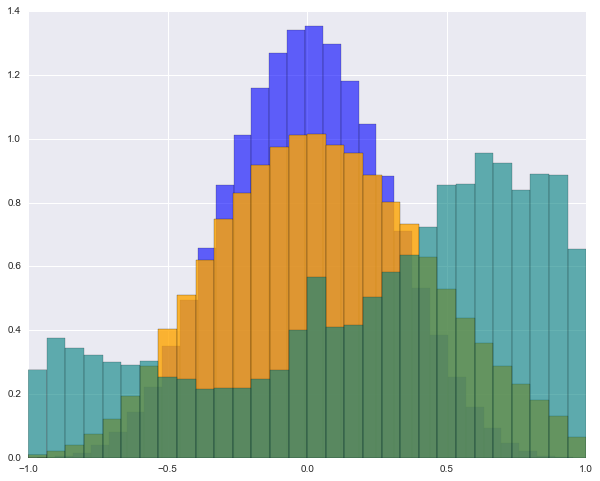

In [195]:
#library = {}
#simulated_coefs = []
parsed_vigenfiles = vigenfiles[1:]

print 'previously parsed: %d' % len(parsed_vigenfiles)

vigenfiles = glob.glob('../vigenstash/*.html')
print 'current collection size: %d' % len(vigenfiles)

print 'previous # of series harvested: %d' % len(library)
for i,page in enumerate(vigenfiles[1:]):
    if page in parsed_vigenfiles:
        continue
    if not i%1000: print 'parsing %s' % page
    
    new_serieses = parse_vigenpage(page)
    if not new_serieses:
        continue
    
    for key,series in new_serieses.items():
        if key not in library.keys():
            library[key] = series

print 'new # of series harvested: %d' % len(library)    

print 'pickling ... \n'
with open('../vigen_serieses.pkl','w') as outpickle:
    pickle.dump({'parsed_vigenfiles':parsed_vigenfiles,'library':library},outpickle)


print 'generating simulated data...\n'    
    
possible_coefs, baddies = get_all_coefs(library)
simulated_coefs = get_simulated_coefs(len(coefs),existing=simulated_coefs)

published_coefs = get_published_coefs()

plt.figure(figsize=(10,8))
plt.hist(simulated_coefs, bins=30, color='blue', alpha=0.6, normed=1);
plt.hold(True)
plt.hist(possible_coefs.values(), bins=30, color='orange', alpha=0.8, normed=1);
plt.hist(published_coefs.values(), bins=30, color='teal', alpha=0.6, normed=1);

In [168]:
def plot_all_coefs(library):
    coefs, baddies = get_all_coefs(library)
    
    plt.hist(coefs, bins=30);
    
def get_simulated_coefs(N, existing=[]):
    simulated_coefs = existing
    remainder = N - len(existing)
    for _ in range(remainder):
        n = random.randint(10,18)
        dat = [[random.random() for i in range(n)] for j in range(2)]
        simulated_coefs.append(scipy.corrcoef(dat)[0][1])
    return simulated_coefs
    
def get_all_coefs(library):
    snitch = _create_snitch(library)
    coefs = {}
    baddies = [] 
    
    for ylen,keys in snitch.iteritems():
        
        if len(snitch[ylen]) < 2:
            continue
        cfs, baddies = _get_coef_matrix(keys, library, baddies)

        coefs = _add_cfs_uniques(coefs,cfs,keys)
    
    return coefs, baddies


def get_published_coefs():
    filename = '../vigenstash/pickle_vigen_latest.pkl'

    with open(filename,'r') as inpickle:
        results = pickle.load(inpickle)

    things,pairs,duds = results.values()
    
    print '# published corr coefs in pickle: %d' % len(pairs) 
    print '# series in pickle: %d' % len(set(things)) 
    print '# possible corrs: %d' % len(set(things))**2 
    print '# proportion of possible published: %f' % (len(pairs)*1.0/len(set(things))**2)
    
    return pairs



def _create_snitch(library):
    snitch = defaultdict(list)
    for key,series in library.iteritems():
        snitch[len(series['y'])].append(key)
    return snitch


def _get_coef_matrix(keys, library, baddies):
    
        mat = []

        for key in keys:
            row = library[key]['y']
            if has_unicodes(row):
                row = type_values(row)
                if has_unicodes(row): 
                    baddies.append(key)
                    continue
                library[key]['y'] = row
                
            mat.append(row)
        cfs = np.corrcoef(mat)
        
        return cfs, baddies
    
        
def _add_cfs_uniques(coefs,cfs,keys):        
    
        for i,row in enumerate(cfs):
            j = len(row[:i])
            if not j: 
                continue
            x = [keys[i]]*j
            y = [keys[jj] for jj in range(j)]
            k = zip(x,y)
            coefs.update(dict(zip(k,row[:i])))

        return coefs


In [190]:
def report_library_quality(library):
    total = len(library)
    ok_vals = [entry['ok'] for entry in library.itervalues()]
    ok = sum(ok_vals)
    print ok_vals[:10]
    print 'library total entries: %d' % total
    print 'entries marked ok: %d' % ok
    print 'percent: %f' % (ok*1.0/total)
    

def parse_vigentable(tablesoup,page):
    x = []
    series = []
    lib = {}
    ok = True
    
    rows = tablesoup.find_all('tr')    
    for row in rows: 
        cells = [cell.text for cell in row.find_all('td')]

        if not cells[0]:
            x = type_values(cells)

        elif len(cells) < 2:
            continue

        else:
            title = cells[0]
            hashtitle = hash(title)
            values = type_values(cells[1:])
            #print values
            series.append((hashtitle,title,values))
            
    if not x:
        for i,elem in enumerate(series):
            split_vals = check_compound(elem[2])

            if split_vals:
                x,y = split_vals
                x = type_values(check_years(x))
                y = type_values(y)

                pop = series[i]
                series[i] = (pop[0],pop[1],y)
            
    if has_unicodes(x):
        x = type_vaues(x)
        
    for thash,name,y in series:
        
        if has_unicodes(y):
            y = check_for_blanks(y)
            y = type_values(y)
            
        headers = ['name','x','y','page','ok']
        entry = dict(zip(headers,[name,x,y,page,ok]))
        lib[thash] = entry

    return lib


def check_for_blanks(y):
    if u' ' in y:
        y[y.index(u' ')] = u' 0'
    return y

def has_unicodes(series):
    return bool(sum([isinstance(c,unicode) for c in series]))

In [154]:
def parse_vigenpage(page):
    soup = soupme(page)
    if not soup:
        return False
        
    try:
        table = soup.find_all('table')[-1]
    except IndexError:
        print page
        return False
    
    return parse_vigentable(table,page)


def soupme(page):
    with open(page,'r') as infile:
        html = infile.read()
        if len(html) < 20:
            return False
        else:
            return BeautifulSoup(html,'html5lib')

        
def type_values(row):

    row = [c for c in row if c]
    try:
        row = [int(val) for val in row]
        return row
    except ValueError:
        pass
    
    try:
        row = [float(val) for val in row]
        return row
    except ValueError:
        pass
        
    row = check_formatted(row) 
        
    return row


def check_compound(row):
    if len(row) == 1:
        try: 
            row = [cell.split(':') for cell in row[0].split(';')]
            x,y = zip(*row)
        except IndexError:
            return False

    return (x,y)


def check_formatted(row):
    row = [cell.replace(',','') for cell in row]
    return row
    
    
def check_years(row):
    row = [c.strip() for c in row if c]
    if sum([c.startswith("'") for c in row]) == len(row):
        return yearconvert(row)
    else: 
        return row
  

def yearconvert(row):
    out = []
    for yearstr in row:
        yearint = int(yearstr[1:])
        if yearint < 20:
            out.append(yearint + 2000)
        else:
            out.append(yearint + 1900)
    return out

In [185]:
for b in baddies: 
    page =  library[b]['page']
    lib = parse_vigenpage(page)
    library[b] = lib[b]
    print library[b], '\n'

{'y': [1, 1, 2, 3, 0, 2, 2, 1, 2, 3, 1, 1, 3, 3, 2, 1, 2, 2, 2, 2, 2, 3, 1, 1, 2, 3, 4, 1, 4], 'x': [1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009], 'ok': True, 'name': u'Number of films Nicolas Cage appeared inFilms (IMDB)', 'page': '../vigenstash/vigen_page_10001.html'} 

{'y': [7, 6, 6, 7, 5, 5, 7, 7, 7, 5, 4, 4, 7, 6, 6, 0, 6, 6, 7, 4, 4, 5, 7, 7, 6, 4, 4, 5, 4, 5, 6], 'x': [1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009], 'ok': True, 'name': u'Games in World SeriesGames (Wikipedia)', 'page': '../vigenstash/vigen_page_10412.html'} 



In [181]:
s = _create_snitch(library)

s[0]
# for key in s[0]:
#     print library[key]['page']
    
#c,b = _get_coef_matrix(ss,library,[])

[]

In [ ]:
for ylen,keys in sorted(snitch.items()):
    print ylen, len(keys)

In [ ]:
library[snitch[21][0]]

In [ ]:
randomvigen = random.choice(vigenfiles)

with open(randomvigen,'r') as infile:
    soup = BeautifulSoup(infile.read(),'html5lib')

# print soup.find_all('table')[-1].prettify()

datatable = soup.find_all('table')[-1]

In [ ]:
snitch = defaultdict(list)

for key,series in library.iteritems():
    snitch[len(series['y'])].append(key)
    
for ylen,count in sorted(snitch.items()):
    print ylen, len(count)


In [ ]:
for r in snitch[ylen]: 
    if type(library[r]['y'][0]) not in [int,float]:
            print r 
            print type(library[r]['y'][0])
            print library[r]['y'][0]
            print '-'
            print library[r]
            print
            print